# Dosimetry data 2019-2021

### An analysis of annual deep dose radiation exposure to employees as recorded by dosimetry badges worn by the employees. Note that "exposure" and "dose" are used interchangeably, as is standard in the field.

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import CSV data:

In [90]:
df19 = pd.read_csv('Doses2019.csv')
df20 = pd.read_csv('Doses2020.csv')
df21 = pd.read_csv('Doses2021.csv')

Keep columns of interest and clean them up:

In [91]:
def extract_columns(df):
    df1 = df[['Location', 'Wearer Number', 'YTD Deep Dose']]
    df1.columns = ['Location', 'Wearer Number', 'Deep Dose']
    return df1

In [92]:
df19_clean = extract_columns(df19)
df20_clean = extract_columns(df20)
df21_clean = extract_columns(df21)

Merge all data together on Wearer Number, the unique identifier for employees (note that this is not a unique identifier for readings, as employees may be issued more than one dosimeter, but isolating the deep dose columns as above should eliminate duplicates):

In [93]:
dose = df19_clean.merge(df20_clean, how="outer", on=['Wearer Number', 'Location'], suffixes=('_2019', ''))

In [94]:
dose = dose.merge(df21_clean, how="outer", on=['Wearer Number', 'Location'], suffixes=('_2020', '_2021'))

NaN values are expected as many individuals were not employed for all 3 years:

In [95]:
dose.head()

,Location,Wearer Number,Deep Dose_2019,Deep Dose_2020,Deep Dose_2021
0,00000AES,153,6.0,0.0,0.0
1,00000AES,154,0.0,0.0,0.0
2,00000AES,161,14.0,0.0,0.0
3,00000AES,788,79.0,22.0,112.0
4,00000AES,679,5.0,0.0,NaN


In [96]:
dose.info

<bound method DataFrame.info of       Location  Wearer Number  Deep Dose_2019  Deep Dose_2020  Deep Dose_2021
0     00000AES            153             6.0             0.0             0.0
1     00000AES            154             0.0             0.0             0.0
2     00000AES            161            14.0             0.0             0.0
3     00000AES            788            79.0            22.0           112.0
4     00000AES            679             5.0             0.0             NaN
...        ...            ...             ...             ...             ...
1909  00000SPR         201016             NaN             NaN             0.0
1910  00000URO           1108             NaN             NaN             0.0
1911  00000URO           1064             NaN             NaN             0.0
1912  00000URO           1107             NaN             NaN             0.0
1913  00000URO           1130             NaN             NaN             0.0

[1914 rows x 5 columns]>

Locations refer to different departments in the hospital. Removing leading zeros from location names:

In [97]:
dose['Location']=dose['Location'].astype('string')
dose['Location']=[string.replace('0','') for string in dose['Location']]

In [98]:
dose.head()

,Location,Wearer Number,Deep Dose_2019,Deep Dose_2020,Deep Dose_2021
0,AES,153,6.0,0.0,0.0
1,AES,154,0.0,0.0,0.0
2,AES,161,14.0,0.0,0.0
3,AES,788,79.0,22.0,112.0
4,AES,679,5.0,0.0,NaN


Initial exploratory analysis of dose values. Exposures were particularly low in 2020. Non-emergency procedures were deprioritized due to the COVID-19 crisis:

In [99]:
print('2019 mean: ' + str(dose['Deep Dose_2019'].mean()))
print('2020 mean: ' + str(dose['Deep Dose_2020'].mean()))
print('2021 mean: ' + str(dose['Deep Dose_2021'].mean()))

2019 mean: 34.79799537393986
2020 mean: 23.502749410840533
2021 mean: 31.40841584158416


In [100]:
print('2019 median: ' + str(dose['Deep Dose_2019'].median()))
print('2020 median: ' + str(dose['Deep Dose_2020'].median()))
print('2021 median: ' + str(dose['Deep Dose_2021'].median()))

2019 median: 5.0
2020 median: 0.0
2021 median: 0.0


Melt the dataframe to facilitate categorical analysis in seaborn:

In [101]:
dose_year=dose
dose_year.columns=['Location', 'Wearer Number', '2019', '2020', '2021']
dose_year=pd.melt(dose_year, id_vars=['Location', 'Wearer Number'], var_name='Year', value_name='Deep Dose in mrem')
dose_year.head()

,Location,Wearer Number,Year,Deep Dose in mrem
0,AES,153,2019,6.0
1,AES,154,2019,0.0
2,AES,161,2019,14.0
3,AES,788,2019,79.0
4,AES,679,2019,5.0


We are only interested in dose to employees, but this data includes spare dosimeters, area monitors, etc. Dropping locations and wearers we are not interested in:

In [102]:
locations_to_drop = ['ED', 'RMA', 'SPR']
wearers_to_drop = [528, 529, 531, 532, 536, 779, 780, 781, 200942, 200943]
to_drop= (dose_year['Location'].isin(locations_to_drop) | dose_year['Wearer Number'].isin(wearers_to_drop))
to_drop

0       False
1       False
2       False
3       False
4       False
        ...  
5737     True
5738    False
5739    False
5740    False
5741    False
Length: 5742, dtype: bool

In [103]:
employee_dose = dose_year[~to_drop]
employee_dose = employee_dose.dropna()
employee_dose

,Location,Wearer Number,Year,Deep Dose in mrem
0,AES,153,2019,6.0
1,AES,154,2019,0.0
2,AES,161,2019,14.0
3,AES,788,2019,79.0
4,AES,679,2019,5.0
...,...,...,...,...
5713,SPC,1095,2021,0.0
5738,URO,1108,2021,0.0
5739,URO,1064,2021,0.0
5740,URO,1107,2021,0.0


A histogram of dose readings. Most doses are less than 100 mrem (note the y scale is cut off):

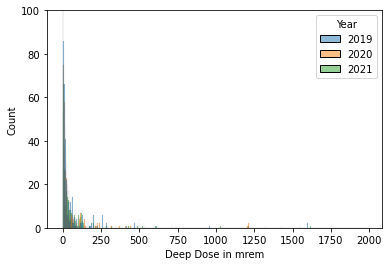

In [104]:
sns.histplot(data=employee_dose, x='Deep Dose in mrem', hue='Year')
plt.ylim(0,100)
plt.show()

A strip plot makes the distribution easier to read:

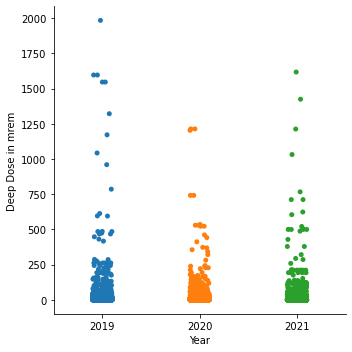

In [105]:
p = sns.catplot(data=employee_dose, x='Year', y='Deep Dose in mrem', kind='strip')

A closer look at the distribution. 88% of readings are below 50 mrem:

In [106]:
employee_dose['Deep Dose in mrem'].value_counts(sort=False, bins=40)

(-1.986, 49.625]       3229
(49.625, 99.25]         199
(99.25, 148.875]         89
(148.875, 198.5]         34
(198.5, 248.125]         32
(248.125, 297.75]        13
(297.75, 347.375]         3
(347.375, 397.0]          5
(397.0, 446.625]          5
(446.625, 496.25]         9
(496.25, 545.875]        11
(545.875, 595.5]          1
(595.5, 645.125]          4
(645.125, 694.75]         0
(694.75, 744.375]         4
(744.375, 794.0]          2
(794.0, 843.625]          0
(843.625, 893.25]         0
(893.25, 942.875]         0
(942.875, 992.5]          1
(992.5, 1042.125]         1
(1042.125, 1091.75]       1
(1091.75, 1141.375]       0
(1141.375, 1191.0]        1
(1191.0, 1240.625]        4
(1240.625, 1290.25]       0
(1290.25, 1339.875]       1
(1339.875, 1389.5]        0
(1389.5, 1439.125]        1
(1439.125, 1488.75]       0
(1488.75, 1538.375]       0
(1538.375, 1588.0]        2
(1588.0, 1637.625]        3
(1637.625, 1687.25]       0
(1687.25, 1736.875]       0
(1736.875, 1786.5]  

In [107]:
employee_dose['Deep Dose in mrem'].value_counts(normalize=True, sort=False, bins=40)

(-1.986, 49.625]       0.883206
(49.625, 99.25]        0.054431
(99.25, 148.875]       0.024344
(148.875, 198.5]       0.009300
(198.5, 248.125]       0.008753
(248.125, 297.75]      0.003556
(297.75, 347.375]      0.000821
(347.375, 397.0]       0.001368
(397.0, 446.625]       0.001368
(446.625, 496.25]      0.002462
(496.25, 545.875]      0.003009
(545.875, 595.5]       0.000274
(595.5, 645.125]       0.001094
(645.125, 694.75]      0.000000
(694.75, 744.375]      0.001094
(744.375, 794.0]       0.000547
(794.0, 843.625]       0.000000
(843.625, 893.25]      0.000000
(893.25, 942.875]      0.000000
(942.875, 992.5]       0.000274
(992.5, 1042.125]      0.000274
(1042.125, 1091.75]    0.000274
(1091.75, 1141.375]    0.000000
(1141.375, 1191.0]     0.000274
(1191.0, 1240.625]     0.001094
(1240.625, 1290.25]    0.000000
(1290.25, 1339.875]    0.000274
(1339.875, 1389.5]     0.000000
(1389.5, 1439.125]     0.000274
(1439.125, 1488.75]    0.000000
(1488.75, 1538.375]    0.000000
(1538.37

According to state regulations, the annual exposure limit to a member of the public from a licensee is 100 mrem (the limit to a radiation worker is 5000 mrem). Certain departments are more likely to fall above this threshold:

In [108]:
dose_above_100 = employee_dose[employee_dose['Deep Dose in mrem']>=100]
dose_above_100['Location'].value_counts()

NM     88
CAR    40
SPC    32
EP     29
RAD    14
RTE    10
AES     4
NEU     4
SL      3
ORT     1
PUL     1
EDY     1
CME     1
Name: Location, dtype: int64

The licensee is required to provide dosimetry to any employee who is likely to recieve more than 10% of the 5000 mrem annual dose:

In [109]:
dose_above_500 = employee_dose[employee_dose['Deep Dose in mrem']>=500]
dose_above_500['Location'].value_counts()

EP     15
SPC    12
CAR     7
RAD     2
RTE     2
Name: Location, dtype: int64

If we make changes to the dosimetry program, it is easiest to do so at the department (location) level, rather than singling out individual employees. One proposal would be to keep all locations where any wearer received 100 mrem or greater in any of the last three years. The remaining locations could be removed from the program:

In [112]:
all_locations = set(employee_dose['Location'].unique())
keep_locations = set(dose_above_100['Location'].unique())
remove_locations = list(all_locations - keep_locations)
remove_locations.sort()
remove_locations

['ASC',
 'BD',
 'CT',
 'DXY',
 'EDN',
 'FRN',
 'LYN',
 'MAM',
 'MOK',
 'MOR',
 'PM',
 'RM',
 'RPO',
 'SLP',
 'UMS',
 'URO',
 'XRY']

The cost to the institution is based on the number of wearers. We are only interested in current employees for cost analysis, so we will focus only on 2021 data:

In [113]:
wearers_to_remove = employee_dose[(employee_dose['Location'].isin(remove_locations))]
wearers_to_remove = wearers_to_remove[wearers_to_remove['Year']=='2021']
wearers_to_remove = wearers_to_remove['Wearer Number'].unique()
number_to_remove = len(wearers_to_remove)
number_to_remove

361

In [114]:
current = employee_dose[employee_dose['Year']=='2021']
current_wearers = len(current['Wearer Number'].unique())
current_wearers

824

In [122]:
ratio = number_to_remove/current_wearers
pct = "{:.2%}".format(ratio)
print(pct)

43.81%


**Conclusion:** The institution could reduce the number of wearers (and therefore the program cost) by 44% without risking either excessive exposure to the employees or violation of state regulations. 

**Assumptions:**
- All employees wear their dosimeters in the correct location
- All employees consistently wear their dosimeters whenever radiation exposure is possible
- Dosimeters are stored in approved locations, and not transported offsite
- Dosimeters are recording exposure accurately and reporting it correctly

**Future Analysis:** This report examines deep dose only. Similar analysis can and should be completed for eye lens dose, shallow dose, and extremity dose before any changes are made to the program. Analysis can be performed for fetal dose, but since a fetal dosimeter must be issued to every employee who declares a pregnancy, no wearers should be removed from dose monitoring based on this analysis. 